<a href="https://colab.research.google.com/github/junweiluo/API_Financial_Analysis/blob/master/Chapter14Ex04_TransferLearning_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is not just about transfer learning but also to get and manipulate tf datasets.

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [3]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [4]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [5]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [6]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [7]:
n_classes = info.features["label"].num_classes
n_classes

5

In [8]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [0]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

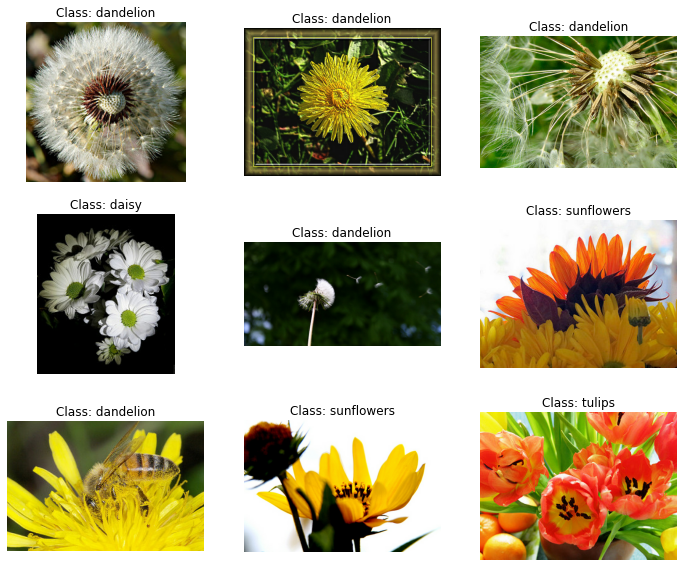

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [0]:
from functools import partial
import tensorflow as tf
from tensorflow import keras

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

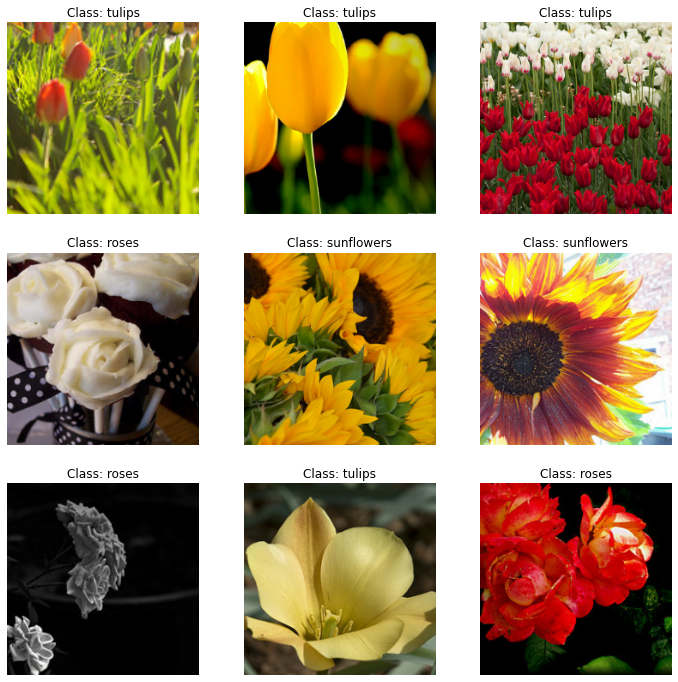

In [13]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

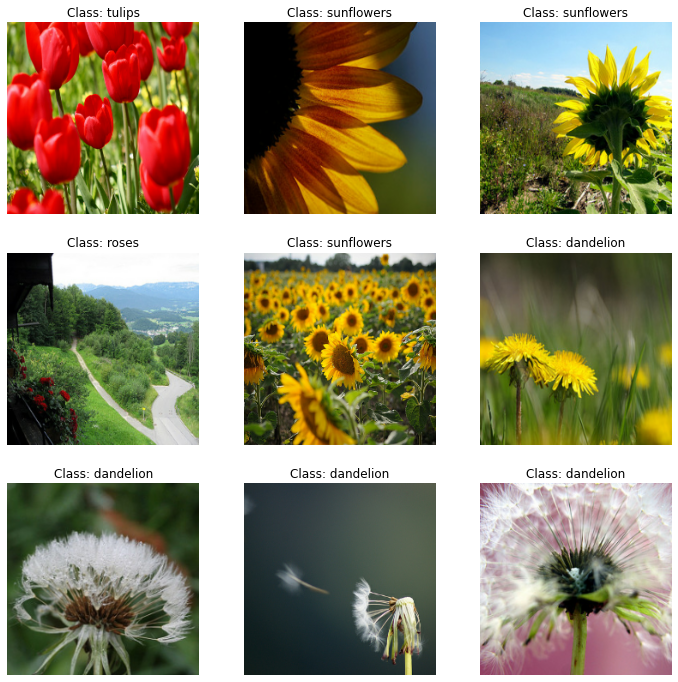

In [14]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [15]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 2s 0us/step


In [16]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [18]:
for layer in base_model.layers:
    layer.trainable = False # lock up the transferred layers.

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01) # lr should be big since it is only for added layers to get rough results.
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 9s 110ms/step - loss: 0.9995 - accuracy: 0.8052 - val_loss: 1.3775 - val_accuracy: 0.8107
Epoch 2/5
86/86 [==============================] - 9s 102ms/step - loss: 0.4509 - accuracy: 0.9041 - val_loss: 0.6198 - val_accuracy: 0.8787
Epoch 3/5
86/86 [==============================] - 9s 101ms/step - loss: 0.2582 - accuracy: 0.9288 - val_loss: 0.5795 - val_accuracy: 0.8824
Epoch 4/5
86/86 [==============================] - 9s 101ms/step - loss: 0.2041 - accuracy: 0.9353 - val_loss: 0.7307 - val_accuracy: 0.8511
Epoch 5/5
86/86 [==============================] - 9s 101ms/step - loss: 0.1503 - accuracy: 0.9549 - val_loss: 0.6288 - val_accuracy: 0.8621


In [19]:
for layer in base_model.layers:
    layer.trainable = True # unlock transferred layers

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001) # smaller learning rate, not to change the transferred layers too much.
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 33s 387ms/step - loss: 0.3157 - accuracy: 0.8983 - val_loss: 0.4257 - val_accuracy: 0.8676
Epoch 2/40
86/86 [==============================] - 33s 381ms/step - loss: 0.1372 - accuracy: 0.9564 - val_loss: 0.4888 - val_accuracy: 0.8438
Epoch 3/40
86/86 [==============================] - 33s 384ms/step - loss: 0.0662 - accuracy: 0.9757 - val_loss: 0.3189 - val_accuracy: 0.8952
Epoch 4/40
86/86 [==============================] - 33s 382ms/step - loss: 0.0515 - accuracy: 0.9844 - val_loss: 0.2227 - val_accuracy: 0.9210
Epoch 5/40
86/86 [==============================] - 33s 380ms/step - loss: 0.0304 - accuracy: 0.9906 - val_loss: 0.3026 - val_accuracy: 0.9228
Epoch 6/40
86/86 [==============================] - 33s 383ms/step - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.2780 - val_accuracy: 0.9320
Epoch 7/40
86/86 [==============================] - 33s 381ms/step - loss: 0.0251 - accuracy: 0.9913 - val_loss: 0.2258 - val_accuracy: 0.9412

In [0]:
model.save("./Xception_transferred.h5")